Dear Student,

In Homework 2, you will delve into the critical topic of imbalanced classification. Many real-world problems are, fortunatelly, inherently imbalanced. For instance, events like being diagnosed with cancer or experiencing a fatal car crash are relatively rare. Fortunately, only some percentage of patients visiting a dermatologist with suspicious moles are found to have cancerous ones. However, the significance of accurately identifying those cancerous cases cannot be overstated.

Classification algorithms like neural networks are unaware of the importance of the minority class and focus solely on minimizing the loss. For example, if 99% of the dataset consists of negative class samples and only 1% represents positive class samples, a model could achieve 99% accuracy simply by predicting all instances as belonging to the negative class.

In this homework, your task is to classify fraudulent credit card transactions. You are tasked with identifying the sampling algorithm that helps to achieve the highest accuracy in predicting fraudulent transactions.

Credit card fraud detection dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. Here is the full description of this dataset:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [2]:
import kagglehub
import shutil
import os
# Download latest version
data_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud", force_download=True)
fpath = os.listdir(data_path)[0]
print(data_path)

# Set the destination folder
destination_folder = "/content"  # Replace with desired folder
shutil.move(os.path.join(data_path,fpath), destination_folder)


100%|██████████| 66.0M/66.0M [00:02<00:00, 23.2MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


'/content/creditcard.csv'


After downloading the dataset, we will load it using the pandas read_csv function. You can explore the features in the dataset. Most of these features are "anonymized" to protect clients' private information, and are transformed using the PCA algorithm, likely, to prevent reverse engineering.

However, two features, "Amount" and "Time", are retained in their original form. The "Class" feature indicates whether a transaction is fraudulent or not and will serve as the target (labels) for the classification task.

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming the downloaded file is named 'creditcard.csv'
df = pd.read_csv('/content/creditcard.csv')

# Print some basic information about the dataframe
print(df.head())  # Print the first 5 rows
print(df.info())   # Print information about the columns and data types
print(df.describe()) # Print descriptive statistics of the dataframe

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Here is a proportion of fradulent transaction samples.

Amount of samples in Class 0: 284315
Amount of samples in Class 1: 492
Proportion: 0.0017304750013189597 : 1


<Axes: title={'center': 'Count (target)'}, xlabel='Class'>

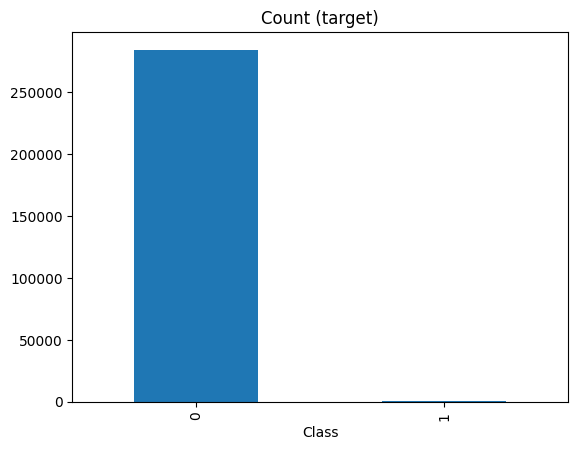

In [4]:
target_count = df["Class"].value_counts()
print('Amount of samples in Class 0:', target_count[0])
print('Amount of samples in Class 1:', target_count[1])
print('Proportion:', target_count[1] / target_count[0], ': 1')

target_count.plot(kind='bar', title='Count (target)')



At first, lets set aside the test set. It is very important to set a test side aside before performing transformation to the dataset.

In [5]:
from sklearn.model_selection import train_test_split
# Separate features and target variable
X = df.drop('Class', axis=1)  # Replace 'target_variable' with your target column name
y = df['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train set: proportion of fraud/non-fraud {len(y_train[y_train == 1])/len(y_train[y_train == 0])}')
print(f'Test set: proportion of fraud/non-fraud {len(y_test[y_test == 1])/len(y_test[y_test == 0])}')


Train set: proportion of fraud/non-fraud 0.0017322412299792043
Test set: proportion of fraud/non-fraud 0.0017234102419808666


The anonimized features are already scaled but "Time" and "Amount" features are not. Let's scale those features. it should not effect scaling of other features.

In [6]:
from sklearn.preprocessing import StandardScaler
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

At first train the model on the original dataset. This would be our baseline, you would need to improve the performance upon it.

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, initializers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

def build_mlp_model_with_he_init(input_dim):
    """
    Builds a Multilayer Perceptron (MLP) model with He Normal weight initialization for ReLU activation.

    Args:
      input_dim: The input shape (number of features).

    Returns:
      A compiled Keras model.
    """
    model = keras.Sequential([
        layers.Dense(64, input_dim=input_dim, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(32, activation='relu', kernel_initializer=initializers.HeNormal()),
        layers.Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
    ])
    return model

# Assuming X_train and y_train are already defined from previous steps

# Get the shape of the training data
input_dim = X_train.shape[1]

# Create the model
model_with_he_init = build_mlp_model_with_he_init(input_dim)

# Compile the model with the Adam optimizer and binary crossentropy loss
model_with_he_init.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping to monitor validation loss and prevent unnecessary training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model and monitor for overfitting
history = model_with_he_init.fit(
    X_train,
    y_train,
    epochs=10,  # Increase epochs to potentially observe overfitting
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Stop if validation loss stops improving
    verbose=1
)

# Evaluate the model performance on the test set
test_loss, test_accuracy = model_with_he_init.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5697/5697 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9930 - loss: 0.0255 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 2/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 3/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 4/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9994 - val_loss: 0.0026
Epoch 5/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9993 - val_loss: 0.0035
Epoch 6/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 7/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9994 - val_loss: 0.0029
Epoch 8/10
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9996 - loss: 0.0017 - val

Test accuracy: 0.9994382262229919
Fantastic accuracy! However lets check how many fraud detection casses were correctly identified.

An imbalanced dataset is one where the classes (in this case, fraudulent and non-fraudulent transactions) are not represented equally. This can lead to misleadingly high accuracy scores if the model simply predicts the majority class most of the time. To get a more accurate picture, we need to use metrics that account for proportion of class samples in the dataset.

Here is the list of metrics that we will use:

1. Confusion matrix
               

```
                Predicted
.................................
      |      | True    | False
      ...........................
      | True |  TP     |  FN  
   GT ...........................
      | False|  FP     |  TN
```

TP - true positive, FN - false negative, FP - false positive, TN - true negative

2. Precision = True Positives / (True Positives + False Positives)

Precision is a fraction of correctly identified fraduelent transactions out of all fradulent pridictions.

Precision is important because we want to avoid inconveniencing legitimate customers by mistakenly flagging their transactions as fraudulent. A high precision means fewer false alarms.

3. Recall = True Positives / (True Positives + False Negatives)

Recall is a fraction of correctly identified fraduelent transactions to all fradulent transactions.
Recall is crucial because we want to catch as many fraudulent transactions as possible. A high recall means fewer fraudulent transactions go undetected.


4. F1-Score = 2 * (Precision * Recall) / (Precision + Recall)

The F1-score is a useful metric when you need to consider both precision and recall. It helps to find a model that performs well in both aspects, catching fraud while minimizing inconvenience to legitimate customers.

5. AUC (Area Under the Receiver Operating Characteristic Curve)
AUC is a measure of the model's ability to distinguish between the two classes (fraudulent and non-fraudulent).
Interpretation: A higher AUC indicates better performance. An AUC of 0.5 represents a model that performs no better than random guessing, while an AUC of 1.0 represents a perfect model.

Great explanation about AUC could be found here:
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

You can also see their explanation of other metrics:
https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the test set using the model with He initialization
y_pred = (model_with_he_init.predict(X_test) > 0.5).astype("int32")

# Calculate the confusion matrix
# Pay attention: the order of labels is switched to make confusion matrix in the standard order
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, F1-score, and AUC
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Confusion Matrix:
[[   78    20]
 [   14 56850]]
Precision: 0.8478260869565217
Recall: 0.7959183673469388
F1-score: 0.8210526315789474
AUC: 0.8978360829418993


As you can see, even though the accuracy of the model is almost 100 percent the accuracy of detecting fradulent transaction is less then optimal. One sixth of fradulent prediction are not fradulent, so 14 people credit cards were frozen for no reason because of your algorithm. More then forth of fradulent transactions go undetected,so 26 people lost money because of your algorithm.

**How can we do better?**

One of the popular technique for dealing with unbalanced dataset is by artificially adding samples to the smaller class, or subtracting elements from the bigger class. The first type of methods are called oversampling and the second type of methods - undersampling.

However you should be carefull when performing this changes to the dataset. Blindly replicating samples from smaller class, can lead to replicating noise and overfitting. Blindly redusing the bigger class can cause loss of information.
For training neural network we will concentrait on algorithms that increase the size of the dataset.

At first you will try to increase the smaller class by randomly oversampling the fradulent detection samples. Then you will try a more sofisticated oversampling algorithm SMOTE(Synthetic Minority Oversampling TEchnique). SMOTE algorithm add points by interpolating existing points in the minority(smaller) class. The next algorithm you will test is ADASYN (Adaptive Synthetic Minority Oversampling Technique). ADASYN focuses on generating data points that are harder to learn, points near the descision boundary.
You can find more information here:
1. https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets
2.
https://imbalanced-learn.org/stable/zzz_references.html#id11





Next you need to train our model on the dataset that were artificially enlarged by Naive Resampling, SMOTE and ADASYN resampling. You need to report Confusion matrix, Prescision, Recall, F1-score, and AUC. Based on this metric you  need to define the most secusfull resampling method.

**Random over-sampling**

In [9]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import layers, models

# Apply Random Over Sampling to balance the dataset
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Print the proportion of fraud/non-fraud in the resampled training set
fraud_ratio_ros = len(y_train_resampled[y_train_resampled == 1]) / len(y_train_resampled[y_train_resampled == 0])
print(f'After Random Over Sampling, the proportion of fraud to non-fraud transactions is {fraud_ratio_ros:.2f}')

# Build the model with He Normal initialization
model_ros = models.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(32, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
])

# Compile the model
model_ros.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the resampled data
history_ros = model_ros.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=10,  # Allow for more epochs to monitor overfitting
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Stop early if validation loss stops improving
    verbose=1
)

# Evaluate the model's performance on the test data
test_loss_ros, test_accuracy_ros = model_ros.evaluate(X_test, y_test)
print(f'Test Accuracy (after Random Over Sampling): {test_accuracy_ros:.4f}')

# Predict the outcomes on the test set
y_pred_ros = (model_ros.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix (with true positives, false positives, etc.)
cm_ros = confusion_matrix(y_test, y_pred_ros, labels=[1, 0])
print("Confusion Matrix (Random Over Sampling):")
print(cm_ros)

# Compute Precision, Recall, F1-Score, and AUC
precision_ros = precision_score(y_test, y_pred_ros)
recall_ros = recall_score(y_test, y_pred_ros)
f1_ros = f1_score(y_test, y_pred_ros)
auc_ros = roc_auc_score(y_test, y_pred_ros)

print("Precision (Random Over Sampling):", precision_ros)
print("Recall (Random Over Sampling):", recall_ros)
print("F1-Score (Random Over Sampling):", f1_ros)
print("AUC (Random Over Sampling):", auc_ros)



After Random Over Sampling, the proportion of fraud to non-fraud transactions is 1.00
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9782 - loss: 0.0640 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9988 - loss: 0.0051 - val_accuracy: 0.9973 - val_loss: 0.0049
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9993 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 6.0813e-04
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 3.5750e-04
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 1.5661e-04
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 3.4465e-04
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 2.4780e-04
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - a

**SMOTE over-sampling**

In [10]:
from imblearn.over_sampling import SMOTE  # For handling class imbalance with SMOTE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import layers, models

# Apply SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print the proportion of fraud/non-fraud in the resampled training set
fraud_ratio_smote = len(y_train_resampled[y_train_resampled == 1]) / len(y_train_resampled[y_train_resampled == 0])
print(f'After applying SMOTE, the proportion of fraud to non-fraud transactions is {fraud_ratio_smote:.2f}')

# Build the model with He Normal initialization
model_smote = models.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(32, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
])

# Compile the model
model_smote.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the resampled data
history_smote = model_smote.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=10,  # Allow for more epochs to monitor overfitting
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Stop early if validation loss stops improving
    verbose=1
)

# Evaluate the model's performance on the test data
test_loss_smote, test_accuracy_smote = model_smote.evaluate(X_test, y_test)
print(f'Test Accuracy (after SMOTE): {test_accuracy_smote:.4f}')

# Predict the outcomes on the test set
y_pred_smote = (model_smote.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix (with true positives, false positives, etc.)
cm_smote = confusion_matrix(y_test, y_pred_smote, labels=[1, 0])
print("Confusion Matrix (SMOTE):")
print(cm_smote)

# Compute Precision, Recall, F1-Score, and AUC
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
auc_smote = roc_auc_score(y_test, y_pred_smote)

print("Precision (SMOTE):", precision_smote)
print("Recall (SMOTE):", recall_smote)
print("F1-Score (SMOTE):", f1_smote)
print("AUC (SMOTE):", auc_smote)



After applying SMOTE, the proportion of fraud to non-fraud transactions is 1.00
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11373/11373 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9802 - loss: 0.0572 - val_accuracy: 0.9967 - val_loss: 0.0122
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - accuracy: 0.9986 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 7.6891e-04
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9999 - val_loss: 9.0534e-04
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 4.0573e-04
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 9.1277e-04
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accur

**ADASYN over-sampling**

In [11]:
from imblearn.over_sampling import ADASYN  # For handling class imbalance with ADASYN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras import layers, models

# Apply ADASYN (Adaptive Synthetic Sampling) to balance the dataset
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Print the proportion of fraud/non-fraud in the resampled training set
fraud_ratio_adasyn = len(y_train_resampled[y_train_resampled == 1]) / len(y_train_resampled[y_train_resampled == 0])
print(f'After applying ADASYN, the proportion of fraud to non-fraud transactions is {fraud_ratio_adasyn:.2f}')

# Build the model with He Normal initialization
model_adasyn = models.Sequential([
    layers.Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(32, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(1, activation='sigmoid')  # Sigmoid output for binary classification
])

# Compile the model
model_adasyn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the resampled data
history_adasyn = model_adasyn.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=10,  # Allow for more epochs to monitor overfitting
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Stop early if validation loss stops improving
    verbose=1
)

# Evaluate the model's performance on the test data
test_loss_adasyn, test_accuracy_adasyn = model_adasyn.evaluate(X_test, y_test)
print(f'Test Accuracy (after ADASYN): {test_accuracy_adasyn:.4f}')

# Predict the outcomes on the test set
y_pred_adasyn = (model_adasyn.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix (with true positives, false positives, etc.)
cm_adasyn = confusion_matrix(y_test, y_pred_adasyn, labels=[1, 0])
print("Confusion Matrix (ADASYN):")
print(cm_adasyn)

# Compute Precision, Recall, F1-Score, and AUC
precision_adasyn = precision_score(y_test, y_pred_adasyn)
recall_adasyn = recall_score(y_test, y_pred_adasyn)
f1_adasyn = f1_score(y_test, y_pred_adasyn)
auc_adasyn = roc_auc_score(y_test, y_pred_adasyn)

print("Precision (ADASYN):", precision_adasyn)
print("Recall (ADASYN):", recall_adasyn)
print("F1-Score (ADASYN):", f1_adasyn)
print("AUC (ADASYN):", auc_adasyn)



After applying ADASYN, the proportion of fraud to non-fraud transactions is 1.00


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9743 - loss: 0.0704 - val_accuracy: 0.9702 - val_loss: 0.1202
Epoch 2/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9988 - loss: 0.0054 - val_accuracy: 0.9581 - val_loss: 0.2097
Epoch 3/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9643 - val_loss: 0.2012
Epoch 4/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9717 - val_loss: 0.1805
Epoch 5/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9744 - val_loss: 0.1125
Epoch 6/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9738 - val_loss: 0.0957
Epoch 7/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9580 - val_loss: 0.1764
Epoch 8/10
11373/11373 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 